- This file is here only for future reference. Changes on the logging format for battery data might make them unusable.

# First analysis of battery logs on Samsung A8 Device

The purpose of this notebook is to validate the current and voltage reading script, searching for any non reasonable reading and if any error was introduced by the abstraction layers (the shell script itself or the sensors integrated to the device).

### Device information

- **Device:** Samsung Galaxy A8
- **SoC:** Samsung Exynos 7 Octa (7885 model) 
- **Kernel Version:** Android Kernel 4.4.13-12606559
- **Instruction Set Architecture:** arm64-v8a
- **big cores**: 2 ARM Cortex-A73
- **LITTLE cores:** 6 ARM Cortex-A53

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## First reading

The file [idle_normal_mode.csv](./csvfiles/idle_normal_mode.csv) has the android system logs for the Samsung A8 on the idle state, meaning that no apps were running but the screen is not blocked. The device was configured so it doesn't turn off the screen during 10 minutes in idle mode. No actions were made on the device during the execution. 

The following information is avaibable on the csv file:

---

<dl>
    <dt><b>timestamp</b></dt>
    <dd>Seconds since the UNIX Epoch 1970-01-01 00:00:00 UTC.</dd>
    <dt><b>current_now</b></dt>
    <dd>The battery current at the moment of the log, measured in microamperes. It is positive value if the phone is charging and negative otherwise. </dd>
    <dt><b>current_avg</b></dt>
    <dd>An average of the current discharge calculated by an specific on chip device sensor. This value is not available on some devices.<br/>
        It's also measured in microamperes.
    </dd>
    <dt><b>voltage_now</b></dt>
    <dd>The battery current at the moment of the log, measured in microvolts. </dd>
    <dt><b>voltage_avg</b></dt>
    <dd>The same as current_avg, but for battery voltage instead. It's also measured in microvolts. </dd>
    <dt><b>temperature</b></dt>
    <dd>The battery's temperature. Measured in tenths of centigrate. ($\frac{1}{10}$ °C) </dd>
    <dt><b>health</b></dt>
    <dd>Represents the health of the battery. It can be one of the following values: [Cold, Dead, Good, Overheat, Over Voltage, Unknown] </dd>
    <dt><b>status</b></dt>
    <dd>The battery current operating status. It can be one of the following values: [Full, Charging, Discharging, Not charging, Unknown] </dd>
</dl>

---

More information on this data is available on the [Android source files documentation](https://android.googlesource.com/kernel/common/+/android-4.4/Documentation/power/power_supply_class.txt)

In [2]:
battery_logs = pd.read_csv('csvfiles/idle_normal_mode.csv')
battery_logs.head()

timestamp  current_now  current_avg  voltage_now  voltage_avg  \
0  1565191514          238          298      4084000      4084000   
1  1565191516          238          298      4084000      4084000   
2  1565191517          238          298      4084000      4084000   
3  1565191518          238          298      4084000      4084000   
4  1565191519          238          298      4084000      4084000   

   temperature health    status  
0          270   Good  Charging  
1          270   Good  Charging  
2          270   Good  Charging  
3          270   Good  Charging  
4          270   Good  Charging

In [3]:
battery_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 8 columns):
timestamp      266 non-null int64
current_now    266 non-null int64
current_avg    266 non-null int64
voltage_now    266 non-null int64
voltage_avg    266 non-null int64
temperature    266 non-null int64
health         266 non-null object
status         266 non-null object
dtypes: int64(6), object(2)
memory usage: 16.8+ KB


- **One first observation that can be made is that the logs are not happening every half second, instead they are fluctuating between 1 and 2 seconds per log.**

## Data cleaning

Some processing needs to be made in order to make the analysis easier. The datetime field is shown as object, but it could be better represented as the pandas datetime object. The health and status are categorical, so they can be represented by the Categorical pandas object.

In [4]:
# Setting datetime column to be the index of the data, so it allows for slicing by time
battery_logs['datetime'] = battery_logs['timestamp'].apply(lambda x: pd.to_datetime(x, unit='s'))
battery_logs.set_index('datetime', inplace=True)

# Adding categorical values
HEALTH_CATEGORIES = ['Good', 'Cold', 'Overheat', 'Death', 'Over Voltage', 'Unspecified Failure', 'Unknown']
STATUS_CATEGORIES = ['Charging', 'Full', 'Discharging', 'Not Charging', 'Unknown']

battery_logs['health'] = pd.Categorical(battery_logs['health'], categories=HEALTH_CATEGORIES)
battery_logs['status'] = pd.Categorical(battery_logs['status'], categories=STATUS_CATEGORIES)

In [5]:
battery_logs.head()

timestamp  current_now  current_avg  voltage_now  \
datetime                                                                 
2019-08-07 15:25:14  1565191514          238          298      4084000   
2019-08-07 15:25:16  1565191516          238          298      4084000   
2019-08-07 15:25:17  1565191517          238          298      4084000   
2019-08-07 15:25:18  1565191518          238          298      4084000   
2019-08-07 15:25:19  1565191519          238          298      4084000   

                     voltage_avg  temperature health    status  
datetime                                                        
2019-08-07 15:25:14      4084000          270   Good  Charging  
2019-08-07 15:25:16      4084000          270   Good  Charging  
2019-08-07 15:25:17      4084000          270   Good  Charging  
2019-08-07 15:25:18      4084000          270   Good  Charging  
2019-08-07 15:25:19      4084000          270   Good  Charging

In [6]:
from datetime import datetime
from functools import partial

byhour = partial(datetime, 2019, 8, 7)
# Example slicing by time
x = byhour(15, 25)
y = byhour(15, 27)

battery_logs.loc[x:y].count()

timestamp      96
current_now    96
current_avg    96
voltage_now    96
voltage_avg    96
temperature    96
health         96
status         96
dtype: int64

- The last thing to do is to change the reading values into more sensible units. (e.g. V, A, °C)

After parsing, the units should be \
current_now: mA (milliAmperes) \
current_avg: mA (milliAmperes) \
voltage_now: V (Volts) \
voltage_avg: V (Volts) \
temperature: °C (Celsius)

In [7]:
battery_logs[['current_now', 'current_avg']] = battery_logs[['current_now', 'current_avg']].apply(lambda x: x / 1e3)
battery_logs[['voltage_now', 'voltage_avg']] = battery_logs[['voltage_now', 'voltage_avg']].apply(lambda x: x / 1e6)
battery_logs['temperature'] = battery_logs['temperature'].apply(lambda x: x / 10)
battery_logs.head()

timestamp  current_now  current_avg  voltage_now  \
datetime                                                                 
2019-08-07 15:25:14  1565191514        0.238        0.298        4.084   
2019-08-07 15:25:16  1565191516        0.238        0.298        4.084   
2019-08-07 15:25:17  1565191517        0.238        0.298        4.084   
2019-08-07 15:25:18  1565191518        0.238        0.298        4.084   
2019-08-07 15:25:19  1565191519        0.238        0.298        4.084   

                     voltage_avg  temperature health    status  
datetime                                                        
2019-08-07 15:25:14        4.084         27.0   Good  Charging  
2019-08-07 15:25:16        4.084         27.0   Good  Charging  
2019-08-07 15:25:17        4.084         27.0   Good  Charging  
2019-08-07 15:25:18        4.084         27.0   Good  Charging  
2019-08-07 15:25:19        4.084         27.0   Good  Charging

Now the data is ready for analysis, as can be seen in the following cell.

In [8]:
_ = battery_logs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2019-08-07 15:25:14 to 2019-08-07 15:30:13
Data columns (total 8 columns):
timestamp      266 non-null int64
current_now    266 non-null float64
current_avg    266 non-null float64
voltage_now    266 non-null float64
voltage_avg    266 non-null float64
temperature    266 non-null float64
health         266 non-null category
status         266 non-null category
dtypes: category(2), float64(5), int64(1)
memory usage: 25.6 KB


## Analysis of the readings

The first thing to notice is that during the execution, the device was fully charged and since it was connected via USB cable, it continued to be charged during the whole experiment.

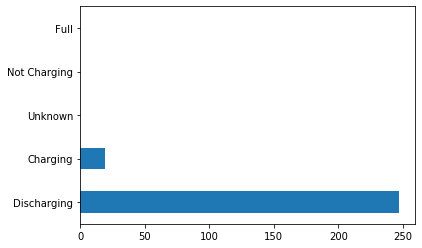

In [9]:
_ = battery_logs['status'].value_counts().plot(kind='barh')

Another thing to look for is how the \*_now values are related to corresponding \*_avg values

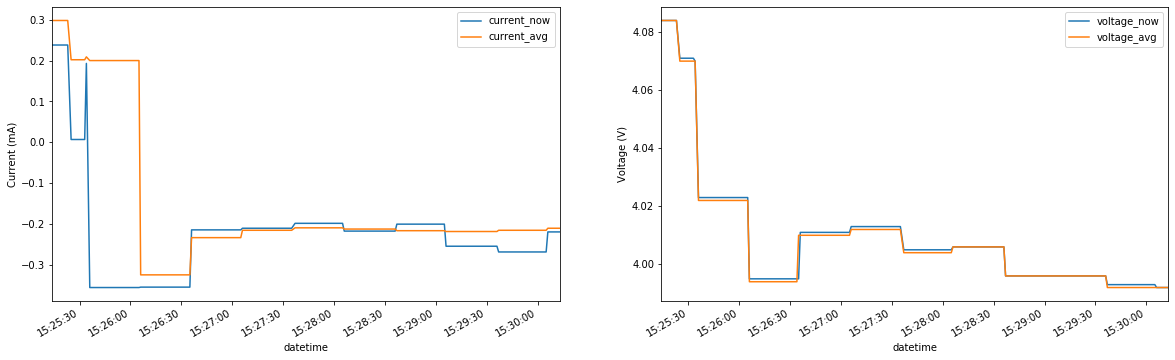

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.set_ylabel('Current (mA)')
ax2.set_ylabel('Voltage (V)')
battery_logs[['current_now', 'current_avg']].plot(ax=ax1, figsize=(20, 6))
_ = battery_logs[['voltage_now', 'voltage_avg']].plot(ax=ax2)

The values looks like being discrete, but I believe this happens because the Android OS takes some time between writes to update the values in /sys. Even though the sampling is every second approximately.

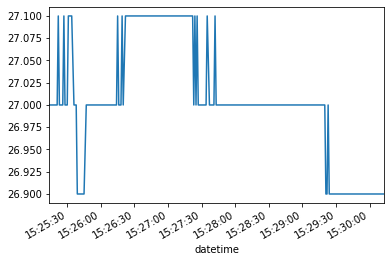

In [14]:
_ = battery_logs['temperature'].plot()